<a href="https://colab.research.google.com/github/oscarserc/LENGUAJE_NLP/blob/main/Transformers_3_HuggingFace_NER_Multilingual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# -----------------------------------------------------------
# PRACTICAS DE: Natural Language Processing with Transformers  - CAPITULO 4
# -----------------------------------------------------------

# GitHub del libro: https://github.com/nlp-with-transformers/notebooks

# Uncomment and run this cell if you're on Colab or Kaggle
!git clone https://github.com/nlp-with-transformers/notebooks.git
%cd notebooks
from install import *
install_requirements()



Cloning into 'notebooks'...
remote: Enumerating objects: 422, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 422 (delta 0), reused 5 (delta 0), pack-reused 416
Receiving objects: 100% (422/422), 24.97 MiB | 29.22 MiB/s, done.
Resolving deltas: 100% (190/190), done.
/content/notebooks
⏳ Installing base requirements ...
✅ Base requirements installed!
⏳ Installing Git LFS ...
✅ Git LFS installed!


#**TAREA: Named Entity Recognition (NER)**.
#Emplearemos Multi-lenguaje.

In [ ]:

# Empezamos con un pequeño ejemplo con NOMBRES DE 'ENTIDADES' ANOTADOS
# --------------------------------------------------------------------

import pandas as pd
tokens = 'Jeff Dean is a computer scientist at Google in California'.split()
# CONVENIO DE ETIQUETADO:
#  · B-PER --> 'B'eggining PERson  (el resto, si es conjunto de palabras se inicia con: 'I')
#  · B-ORG --> 'B'eggining ORGanization
#  · B-LOC --> 'B'eggining LOCation
labels = ['B-PER', 'I-PER', '0', '0', '0', '0', '0', 'B-ORG', '0', 'B-LOC']

df = pd.DataFrame(data=[tokens, labels], index=['Tokens', 'Tags'])
df


,0,1,2,3,4,5,6,7,8,9
Tokens,Jeff,Dean,is,a,computer,scientist,at,Google,in,California
Tags,B-PER,I-PER,0,0,0,0,0,B-ORG,0,B-LOC


#Rastreamos un poco las BASES DE DATOS disponibles para tareas multilenguaje.


In [ ]:

from datasets import get_dataset_config_names

# Rastreamos conjuntos de datos de entrenamiento para la tarea:
#
# --------
#  XTREME -> Cross-lingual TRansfer Evaluation of Multilingual Encoders
# --------
#
# En concreto buscamos el BENCHMARK: PAN-X (Por el paper: Pan, X. et al. (2017))

xtreme_subsets = get_dataset_config_names('xtreme')
print(f'----> XTREME has {len(xtreme_subsets)} configurations')



Downloading:   0%|          | 0.00/9.04k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/23.1k [00:00<?, ?B/s]

----> XTREME has 183 configurations


In [ ]:

panx_subsets = [s for s in xtreme_subsets if s.startswith('PAN')]
panx_subsets[:3]

# Hay 40
# len(panx_subsets)

# Vemos el formato de los archivos: PAN-X.__
# la extensión alude al idioma


['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg']

#Cargamos algunos CORPUS, por ejemplo del alemán (PAN-X.de).

In [ ]:

from datasets import load_dataset

load_dataset('xtreme', name='PAN-X.de')


Downloading:   0%|          | 0.00/234M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/2fc6b63c5326cc0d1f73060649612889b3a7ed8a6605c91cecdbd228a7158b17. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 20000
    })
})

#**Creamos un CORPUS para entrenamiento, empleando varios de los datasets**
#(tipo: PAN-X._idioma_).
#En concreto: de(alemán), fr(francés), it(italiano) y en(inglés).
#*Con esto pretendemos crear un traductor que se maneje con comunicaciones en SUIZA, que se suelen hacer en estos 4 idiomas*.

In [ ]:

# Empleamos una estructura: DEFAULTDICT
#
# · key   --> código del lenguaje
# · value --> corpus PAN-X (del tipo: DatasetDict)

from collections import defaultdict
from datasets import DatasetDict

lenguajes   = ['de', 'fr', 'it', 'en']
fracciones  = [0.629, 0.229, 0.084, 0.059]

# Devolver un DatasetDict si la KEY no existe
panx_ch = defaultdict(DatasetDict)

for lenguaje, fraccion in zip(lenguajes, fracciones):
  # Carga del CORPUS MONOLINGÜE
  ds = load_dataset('xtreme', name=f'PAN-X.{lenguaje}')
  # Mezclamos los índices, y hacemos un DOWNSAMPLE para ajustarnos a las proporciones que queremos
  for split in ds:
    panx_ch[lenguaje][split] = (ds[split].shuffle(seed=0).select(range(int(fraccion*ds[split].num_rows))))



Reusing dataset xtreme (/root/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/2fc6b63c5326cc0d1f73060649612889b3a7ed8a6605c91cecdbd228a7158b17)


  0%|          | 0/3 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/2fc6b63c5326cc0d1f73060649612889b3a7ed8a6605c91cecdbd228a7158b17. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/2fc6b63c5326cc0d1f73060649612889b3a7ed8a6605c91cecdbd228a7158b17. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/2fc6b63c5326cc0d1f73060649612889b3a7ed8a6605c91cecdbd228a7158b17. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

#Comprobamos el DEFAULTDICT que hemos creado. Su estructura es la siguiente.

In [ ]:

panx_ch


defaultdict(datasets.dataset_dict.DatasetDict,
            {'de': DatasetDict({
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 6290
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 6290
    })
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 12580
    })
}),
             'en': DatasetDict({
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 590
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 590
    })
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 1180
    })
}),
             'fr': DatasetDict({
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 2290
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 2290
    })
    train: Dataset(

In [ ]:

import pandas as pd

pd.DataFrame({lang: [panx_ch[lang]['train'].num_rows] for lang in lenguajes},
             index = ['Number of training examples'])



,de,fr,it,en
Number of training examples,12580,4580,1680,1180


In [ ]:

# Probamos el acceso a los DATOS. Empezamos con el primer elemento (0):
#    >>> panx_ch['de']['train'][0]
#
#    >>> {'langs':    ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de'],
#         'ner_tags': [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0],
#         'tokens':   ['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.']}

# Para iterar por el DICCIONARIO, emplearemos: 
#                   __.items()

element = panx_ch['de']['train'][0]
for key, value in element.items():
  print(f'CLAVE {key} : VALORES {value}')



CLAVE tokens : VALORES ['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.']
CLAVE ner_tags : VALORES [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]
CLAVE langs : VALORES ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']


In [ ]:

# AHORA COMPROBAMOS CADA UNA DE ESTAS 3 FEATURES QUE ESTÁN GUARDADAS EN EL DICCIONARIO
# ------------------------------------------------------------------------------------

for key, value in panx_ch['de']['train'].features.items():
  print(f'FEATURE {key}: {value}')



FEATURE tokens: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
FEATURE ner_tags: Sequence(feature=ClassLabel(num_classes=7, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], names_file=None, id=None), length=-1, id=None)
FEATURE langs: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


In [ ]:

# AHORA ACCEDEMOS UN POCO MÁS DENTRO DE UNA DE LAS FEATURES
# ---------------------------------------------------------

etiquetas = panx_ch['de']['train'].features['ner_tags'].feature
print(etiquetas)



ClassLabel(num_classes=7, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], names_file=None, id=None)


In [ ]:

# Las FEATURES de tipo LABEL tienen un método asociado: ____.int2str()
# que permite devolver el valor numérico asociado a la cadena

def create_tag_names(batch):
  return {'ner_tags_str': [etiquetas.int2str(idx) for idx in batch['ner_tags']]}

panx_de = panx_ch['de'].map(create_tag_names)  
panx_de


Parameter 'function'=<function create_tag_names at 0x7fc925835cb0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/6290 [00:00<?, ?ex/s]

  0%|          | 0/6290 [00:00<?, ?ex/s]

  0%|          | 0/12580 [00:00<?, ?ex/s]

DatasetDict({
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 6290
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 6290
    })
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 12580
    })
})

In [ ]:

de_example = panx_de['train'][0]
pd.DataFrame([de_example['tokens'], de_example['ner_tags_str']], ['Tokens', 'Tags'])



,0,1,2,3,4,5,6,7,8,9,10,11
Tokens,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
Tags,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O


#Contamos cada una de las ENTIDADES que tenemos en la base de datos.

In [ ]:

from collections import Counter

split2freqs = defaultdict(Counter)
for split, dataset in panx_de.items():
  for row in dataset['ner_tags_str']:
    for tag in row:
      if tag.startswith('B'):
        tag_type = tag.split('-')[1]
        split2freqs[split][tag_type] += 1

pd.DataFrame.from_dict(split2freqs, orient='index')


,ORG,LOC,PER
validation,2683,3172,2893
test,2573,3180,3071
train,5366,6186,5810


# ========================================

#Ahora sí, pasamos a los:
#**TRANSFORMERS MULTILINGUES**.

#1) Empezamos por la Tokenización.

In [ ]:

from transformers import AutoTokenizer

bert_model_name = 'bert-base-cased'
xlmr_model_name = 'xlm-roberta-base'

bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)



Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

In [ ]:

# Probamos con un pequeño ejemplo
# -------------------------------

text = 'Jack Sparrow loves New York!'
 
#  >>>  bert_tokenizer(text)
#  >>>  {'input_ids': [101, 2132, 23665, 8674, 7871, 1203, 1365, 106, 102], 
#        'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 
#        'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()

bert_tokens


['[CLS]', 'Jack', 'Spa', '##rrow', 'loves', 'New', 'York', '!', '[SEP]']

In [ ]:

df = pd.DataFrame([bert_tokens, xlmr_tokens], index=['BERT', 'XLM-R'])
df


,0,1,2,3,4,5,6,7,8,9
BERT,[CLS],Jack,Spa,##rrow,loves,New,York,!,[SEP],None
XLM-R,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>


In [ ]:

# Y reconstruimos el texto de partida
# -----------------------------------

''.join(xlmr_tokens).replace(u'\u2581', ' ')


'<s> Jack Sparrow loves New York!</s>'

#2) Creamos un MODELO adaptado para la clasificación de los TOKENS.

In [ ]:

import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
  config_class = XLMRobertaConfig

  def __init__(self, config):
    super().__init__(config)
    self.num_labels = config.num_labels
    # CARGA DEL CUERPO DE LA ARQUITECTURA
    self.roberta = RobertaModel(config, add_pooling_layer=False)
    # CONFIGURAMOS LA CABEZA CLASIFICADORA DE TOKENS
    self.dropout    = nn.Dropout(config.hidden_dropout_prob)
    self.classifier = nn.Linear(config.hidden_size, config.num_labels)
    # CARGAMOS E INICIALIZAMOS LOS PESOS
    self.init_weights()

  def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None, **kwargs):
    # USAMOS EL CUERPO DE LA ESTRUCTURA ----> objetivo: Obtener las REPRESENTACIONES del ENCODER
    outputs = self.roberta(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, **kwargs)
    # APLICAMOS EL CLASIFICADOR A LA REPRESENTACIÓN DEL ENCODER
    sequence_output = self.dropout(outputs[0])
    logits          = self.classifier(sequence_output)
    # CALCULAMOS LA PÉRDIDA
    loss = None
    if labels is not None:
      loss_fct = nn.CrossEntropyLoss()
      loss     = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
    # DEVOLVEMOS UN OBJETO CON LA SALIDA DEL MODELO
    
    return TokenClassifierOutput(loss=loss, logits=logits, 
                                 hidden_states=outputs.hidden_states, 
                                 attentions=outputs.attentions)    



#3) Cargamos un Modelo adaptado.

In [ ]:

index2tag = {idx: tag for idx, tag in enumerate(etiquetas.names)}
tag2index = {tag: idx for idx, tag in enumerate(etiquetas.names)}


In [ ]:

from transformers import AutoConfig

xlmr_config = AutoConfig.from_pretrained(xlmr_model_name, 
                                         num_labels=etiquetas.num_classes, 
                                         id2label=index2tag, 
                                         label2id=tag2index)


In [ ]:

import torch

DEVICE     = 'cuda' if torch.cuda.is_available() else 'cpu'
xlmr_model = (XLMRobertaForTokenClassification
              .from_pretrained(xlmr_model_name, config=xlmr_config)
              .to(DEVICE))


Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifie

In [ ]:

input_ids = xlmr_tokenizer.encode(text, return_tensors='pt')
pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index=['Tokens', 'Input IDs'])


,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Input IDs,0,21763,37456,15555,5161,7,2356,5753,38,2


In [ ]:

outputs     = xlmr_model(input_ids.to(DEVICE)).logits
predictions = torch.argmax(outputs, dim=-1)

print(f'Number of tokens in sequence: {len(xlmr_tokens)}')
print(f'Shape of outputs: {outputs.shape}')


Number of tokens in sequence: 10
Shape of outputs: torch.Size([1, 10, 7])


In [ ]:

preds = [etiquetas.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([xlmr_tokens, preds], index=['Tokens', 'Tags'])


,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Tags,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG


In [ ]:

def tag_text(text, tags, model, tokenizer):
  # Obtener TOKENS con caracteres especiales
  tokens = tokenizer(text).tokens()
  # Codificar la secuencia en IDs
  input_ids = xlmr_tokenizer(text, return_tensors='pt').input_ids.to(DEVICE)
  # Obtener PREDICCIONES como una distribución sobre 7 posibles clases
  outputs = model(input_ids)[0]
  # Obtenemos la clase más probable (ARGMAX)
  predictions = torch.argmax(outputs, dim=2)
  # Convertimos en un DATAFRAME
  preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
  
  return pd.DataFrame([tokens, preds], index=['Tokens', 'Tags'])



#4) Tokenizamos textos para NER (Named Entity Recognition).

In [ ]:

words, labels = de_example['tokens'], de_example['ner_tags']


In [ ]:

tokenized_input = xlmr_tokenizer(de_example['tokens'], is_split_into_words=True)
tokens          = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input['input_ids'])


In [ ]:

pd.DataFrame([tokens], index=['Tokens'])


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>


In [ ]:

word_ids = tokenized_input.word_ids()
pd.DataFrame([tokens, word_ids], index=['Tokens', 'Word IDs'])


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None


In [ ]:

previous_word_idx = None
label_ids         = []

for word_idx in word_ids:
  if word_idx is None or word_idx == previous_word_idx:
    label_ids.append(-100)
  elif word_idx != previous_word_idx:
    label_ids.append(labels[word_idx])
  previous_word_idx = word_idx    

labels = [index2tag[l] if (l != -100) else 'IGN' for l in label_ids]
index  = ['Tokens', 'Word IDs', 'Label IDs', 'Labels']

pd.DataFrame([tokens, word_ids, label_ids, labels], index=index)


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None
Label IDs,-100,0,0,-100,0,0,5,-100,-100,6,...,5,-100,-100,-100,6,-100,-100,0,-100,-100
Labels,IGN,O,O,IGN,O,O,B-LOC,IGN,IGN,I-LOC,...,B-LOC,IGN,IGN,IGN,I-LOC,IGN,IGN,O,IGN,IGN


In [ ]:

def tokenize_and_align_labels(examples):
  tokenized_inputs = xlmr_tokenizer(examples['tokens'], truncation=True,
                                    is_split_into_words=True)
  
  labels = []
  for idx, label in enumerate(examples['ner_tags']):
    word_ids = tokenized_inputs.word_ids(batch_index=idx)
    previous_word_idx = None
    label_ids = []
    for word_idx in word_ids:
      if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100)
      else:
        label_ids.append(label[word_idx])
      previous_word_idx = word_idx
    labels.append(label_ids)
  tokenized_inputs['labels'] = labels

  return tokenized_inputs        



In [ ]:

def encode_panx_dataset(corpus):
  return corpus.map(tokenize_and_align_labels, batched=True,
                    remove_columns=['langs', 'ner_tags', 'tokens'])


In [ ]:

panx_de_encoded = encode_panx_dataset(panx_ch['de'])


  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

In [ ]:

panx_de_encoded


DatasetDict({
    validation: Dataset({
        features: ['attention_mask', 'input_ids', 'labels'],
        num_rows: 6290
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'labels'],
        num_rows: 6290
    })
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'labels'],
        num_rows: 12580
    })
})

#5) Medidas de PERFORMANCE.

In [ ]:

from seqeval.metrics import classification_report

y_true = [['O', 'O', 'O', 'B-MISC', 'I-MISC', 'I-MISC', 'O'],
          ['B-PER', 'I-PER', 'O']]

y_pred = [['O', 'O', 'B-MISC', 'I-MISC', 'I-MISC', 'I-MISC', 'O'],
          ['B-PER', 'I-PER', 'O']]

print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



In [ ]:

import numpy as np

def align_predictions(predictions, label_ids):
  preds = np.argmax(predictions, axis=2)
  batch_size, seq_len = preds.shape
  labels_list, preds_list = [], []

  for batch_idx in range(batch_size):
    example_labels, example_preds = [], []
    for seq_idx in range(seq_len):
      # Ignorar etiquetas IDs = -100
      if label_ids[batch_idx, seq_idx] != -100:
        example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
        example_preds.append(index2tag[preds[batch_idx][seq_idx]])

    labels_list.append(example_labels)
    preds_list.append(example_preds)

  return preds_list, labels_list      


#**Fine-Tuning XLM-RoBERTa**.

In [ ]:

from transformers import TrainingArguments

num_epochs = 3
batch_size = 24
logging_steps = len(panx_de_encoded['train']) // batch_size

model_name    = f'{xlmr_model_name}-finetuned-panx-de'
training_args = TrainingArguments(
    output_dir=model_name, log_level='error', num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size =batch_size,
    evaluation_strategy='epoch',
    save_steps=1e6, weight_decay=0.01, disable_tqdm=False,
    logging_steps=logging_steps
    #, push_to_hub=True   <---- SI ESTÁ ACTIVO DA ERROR EN EL TRAINER, y exige que se haga un login a HUGGING FACE
)



In [ ]:

# Si queremos trasladar resultados y avances que hacemos a HUGGING FACE
# bastará con hacer un 'login':
#          from huggingface_hub import notebook_login
#          notebook_login()


In [ ]:

from seqeval.metrics import f1_score

def compute_metrics(eval_pred):
  y_pred, y_true = align_predictions(eval_pred.predictions,
                                     eval_pred.label_ids)
  
  return {'f1': f1_score(y_true, y_pred)}


In [ ]:

from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)


In [ ]:

def model_init():
  return (XLMRobertaForTokenClassification
          .from_pretrained(xlmr_model_name, config=xlmr_config)
          .to(DEVICE))


In [ ]:

%env TOKENIZERS_PARALLELISM=false


env: TOKENIZERS_PARALLELISM=false


In [ ]:

from transformers import Trainer

trainer = Trainer(model_init=model_init, args=training_args,
                  data_collator=data_collator, compute_metrics=compute_metrics,
                  train_dataset=panx_de_encoded['train'],
                  eval_dataset=panx_de_encoded['validation'],
                  tokenizer=xlmr_tokenizer)


In [ ]:

# ------------------------------------
# CPU: 5% y aproximadamente 10 minutos
# ------------------------------------

# PROBAR ACTIVANDO LA GPU

trainer.train()
# trainer.push_to_hub(commit_message='Training completed!')


Epoch,Training Loss,Validation Loss,F1
1,0.257500,0.162098,0.829154
2,0.128700,0.137820,0.852643
3,0.083100,0.137173,0.862095


TrainOutput(global_step=1575, training_loss=0.1562936602698432, metrics={'train_runtime': 530.0984, 'train_samples_per_second': 71.194, 'train_steps_per_second': 2.971, 'total_flos': 863012377186080.0, 'train_loss': 0.1562936602698432, 'epoch': 3.0})

In [ ]:

df = pd.DataFrame(trainer.state.log_history)[['epoch', 'loss', 'eval_loss', 'eval_f1']]
df = df.rename(columns={'epoch'    : 'Epoch', 
                        'loss'     : 'Training Loss',
                        'eval_loss': 'Validation Loss',
                        'eval_f1'  : 'F1'})
df['Epoch']                   = df['Epoch'].apply(lambda x: round(x))
df['Training Loss']           = df['Training Loss'].ffill()
df[['Validation Loss', 'F1']] = df[['Validation Loss', 'F1']].bfill().ffill()
df.drop_duplicates()


,Epoch,Training Loss,Validation Loss,F1
0,1,0.2575,0.162098,0.829154
2,2,0.1287,0.137820,0.852643
4,3,0.0831,0.137173,0.862095


In [ ]:

text_de = 'Jeff Dean ist ein Informatiker bei Google in Kalifornien'
tag_text(text_de, etiquetas, trainer.model, xlmr_tokenizer)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁ist,▁ein,▁Informati,ker,▁bei,▁Google,▁in,▁Kaliforni,en,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC,I-LOC,O


#**Análisis de ERRORES**.

In [ ]:

from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
  # Convertimos el 'DICCIONARIO DE LISTAS' en una 'LISTA DE DICCIONARIOS' apropiada para el DATA COLLATOR
  features = [dict(zip(batch, t)) for t in zip(*batch.values())]
  # PADDING de INPUTS y ETIQUETAS, y colocar los TENSORES en el DEVICE
  batch     = data_collator(features)
  input_ids = batch['attention_mask'].to(DEVICE)
  attention_mask = batch['attention_mask'].to(DEVICE)
  labels    = batch['labels'].to(DEVICE)
  with torch.no_grad():
    # Enviamos datos al MODELO
    output = trainer.model(input_ids, attention_mask)
    # Predecimos CLASE con el valor más álto en el LOGIT
    # (Logit.size: [batch_size, sequence_length, classes])
    predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
  # Calculamos la pérdida por token tras aplanar la DIMENSIÓN BATCH con VIEW
  loss = cross_entropy(output.logits.view(-1, 7),
                       labels.view(-1), reduction='none')
  # Recuperamos la DIMENSIÓN BATCH y convertimos en un ARRAY NUMPY
  loss = loss.view(len(input_ids), -1).cpu().numpy()

  return {'loss': loss, 'predicted_label': predicted_label}  


In [ ]:

valid_set = panx_de_encoded['validation']
valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size=32)
df = valid_set.to_pandas()


  0%|          | 0/197 [00:00<?, ?ba/s]

In [ ]:

index2tag[-100] = 'IGN'
df['input_tokens']    = df['input_ids'].apply(lambda x: xlmr_tokenizer.convert_ids_to_tokens(x))
df['predicted_label'] = df['predicted_label'].apply(lambda x: [index2tag[i] for i in x])
df['labels']          = df['labels'].apply(lambda x: [index2tag[i] for i in x])
df['loss']            = df.apply(lambda x: x['loss'][:len(x['input_ids'])], axis=1)
df['predicted_label'] = df.apply(lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)
df.head(1)


,attention_mask,input_ids,labels,loss,predicted_label,input_tokens
0,"[1, 1, 1, 1, 1, 1, 1]","[0, 10699, 11, 15, 16104, 1388, 2]","[IGN, B-ORG, IGN, I-ORG, I-ORG, I-ORG, IGN]","[0.0, 4.05675, 0.0, 3.515177, 3.515177, 3.5151...","[O, O, O, O, O, O, O]","[<s>, ▁Ham, a, ▁(, ▁Unternehmen, ▁), </s>]"


In [ ]:

df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens['loss'] = df_tokens['loss'].astype(float).round(2)
df_tokens.head(7)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,attention_mask,input_ids,labels,loss,predicted_label,input_tokens
0,1,10699,B-ORG,4.06,O,▁Ham
0,1,15,I-ORG,3.52,O,▁(
0,1,16104,I-ORG,3.52,O,▁Unternehmen
0,1,1388,I-ORG,3.52,O,▁)
1,1,56530,O,0.11,O,▁WE
1,1,83982,B-ORG,4.06,O,▁Luz
1,1,10,I-ORG,3.52,O,▁a


In [ ]:

(
    df_tokens.groupby('input_tokens')[['loss']]
 .agg(['count', 'mean', 'sum'])
 .droplevel(level=0, axis=1)  # Eliminamos columnas multinivel
 .reset_index()
 .round(2)
 .head(10)
 .T
)


,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁!,▁%,▁&,▁',▁'',▁(,▁),▁*,▁**
count,6066,9,20,19,2133,2898,246,246,12,159
mean,0.3,1.63,0.11,3.58,0.12,0.12,4.1,4.1,0.11,0.11
sum,1842.1,14.63,2.2,68.08,256.74,357.76,1009.54,1007.92,1.32,17.49


In [ ]:

(
    df_tokens.groupby('labels')[['loss']]
 .agg(['count', 'mean', 'sum'])
 .droplevel(level=0, axis=1)
 .sort_values(by='mean', ascending=False)
 .reset_index()
 .round(2)
 .T
)


,0,1,2,3,4,5,6
labels,B-LOC,I-LOC,I-PER,B-ORG,B-PER,I-ORG,O
count,3172,1462,4139,2683,2893,3820,43648
mean,5.13,4.47,4.12,4.06,3.94,3.52,0.11
sum,16272.36,6535.14,17052.68,10892.98,11398.42,13446.4,4801.28


#Matrix de Confusión

In [ ]:

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize='true')
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
  plt.title('Normalized confusion matrix')
  plt.show()


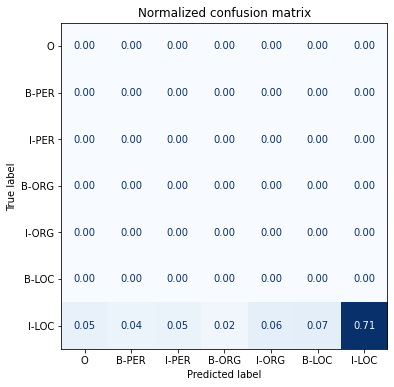

In [ ]:

plot_confusion_matrix(df_tokens['labels'], df_tokens['predicted_label'], etiquetas.names)


In [ ]:

def get_samples(df):
  for _, row in df.iterrows():
    labels, preds, tokens, losses = [], [], [], []
    for i, mask in enumerate(row['attention_mask']):
      if i not in {0, len(row['attention_mask'])}:
        labels.append(row['labels'][i])
        preds.append(row['predicted_label'][i])
        tokens.append(row['input_tokens'][i])
        # losses.append(f"{row['loss'][i]:.2f}")  # AQUÍ DA ERROR sintaxis inválida
    df_tmp = pd.DataFrame({'tokens': tokens, 'labels': labels,
                           #'preds' : preds,  'losses': losses})  
                           'preds' : preds}).T   
    yield df_tmp

df['total_loss'] = df['loss'].apply(sum)
df_tmp = df.sort_values(by='total_loss', ascending=False).head(3)

for sample in get_samples(df_tmp):
  display(sample)


,0,1,2,3,4,5,6,7,8,9,...,84,85,86,87,88,89,90,91,92,93
tokens,▁Weitere,▁Version,en,▁exist,ieren,▁von,▁Sid,ney,▁Be,chet,...,spo,on,▁und,▁Co,o,tie,▁Williams,▁,.,</s>
labels,O,O,IGN,O,IGN,O,B-PER,IGN,I-PER,IGN,...,IGN,IGN,O,B-PER,IGN,IGN,I-PER,O,IGN,IGN
preds,O,O,O,O,O,O,O,O,O,O,...,O,O,O,O,O,O,O,O,O,O


,0,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,73
tokens,▁Dabei,▁spielt,e,▁die,▁Gruppe,▁mit,▁Band,s,▁wie,▁Pier,...,▁Ghost,▁Inside,▁und,▁A,▁Day,▁to,▁Remember,▁,.,</s>
labels,O,O,IGN,O,O,O,O,IGN,O,B-ORG,...,I-ORG,I-ORG,O,B-ORG,I-ORG,I-ORG,I-ORG,O,IGN,IGN
preds,O,O,O,O,O,O,O,O,O,O,...,O,O,O,O,O,O,O,O,O,O


,0,1,2,3,4,5,6,7,8,9,...,66,67,68,69,70,71,72,73,74,75
tokens,▁Sie,▁ist,▁Sitz,▁des,▁Europäische,n,▁Gericht,sho,fes,▁(,...,fa,zil,ität,▁(,▁EF,SF,▁),▁,.,</s>
labels,O,O,O,O,B-ORG,IGN,I-ORG,IGN,IGN,I-ORG,...,IGN,IGN,IGN,I-ORG,I-ORG,IGN,I-ORG,O,IGN,IGN
preds,O,O,O,O,O,O,O,O,O,O,...,O,O,O,O,O,O,O,O,O,O


In [ ]:

df_tmp = df.loc[df['input_tokens'].apply(lambda x: u'\u2581(' in x)].head(2)
for sample in get_samples(df_tmp):
  display(sample)


,0,1,2,3,4,5
tokens,▁Ham,a,▁(,▁Unternehmen,▁),</s>
labels,B-ORG,IGN,I-ORG,I-ORG,I-ORG,IGN
preds,O,O,O,O,O,O


,0,1,2,3,4,5,6,7
tokens,▁Kesk,kül,a,▁(,▁Mart,na,▁),</s>
labels,B-LOC,IGN,IGN,I-LOC,I-LOC,IGN,I-LOC,IGN
preds,O,O,O,O,O,O,O,O


#**Cross-Lingual Transfer**.

In [ ]:

def get_f1_score(trainer, dataset):
  return trainer.predict(dataset).metrics['test_f1']


In [ ]:

f1_scores = defaultdict(dict)
f1_scores['de']['de'] = get_f1_score(trainer, panx_de_encoded['test'])

# Si hay comillas simples: '  ' en el interior,
# poner dobles:  print(f"  "), si no sale error
print(f"F1-score of [de] model on [de] dataset: {f1_scores['de']['de']:.3f}")



F1-score of [de] model on [de] dataset: 0.870


In [ ]:

text_fr = 'Jeff Dean est informaticien chez Google en Californie'
tag_text(text_fr, etiquetas, trainer.model, xlmr_tokenizer)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁est,▁informatic,ien,▁chez,▁Google,▁en,▁Cali,for,nie,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,B-ORG,O,B-LOC,B-LOC,I-LOC,O


#Evaluamos en cada uno de los idiomas.

In [ ]:

def evaluate_lang_performance(lang, trainer):
  panx_ds = encode_panx_dataset(panx_ch[lang])
  return get_f1_score(trainer, panx_ds['test'])


In [ ]:

f1_scores['de']['fr'] = evaluate_lang_performance('fr', trainer)
print(f"F1-score of [de] model on [fr] dataset: {f1_scores['de']['fr']:.3f}")


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

F1-score of [de] model on [fr] dataset: 0.700


In [ ]:

f1_scores['de']['it'] = evaluate_lang_performance('it', trainer)
print(f"F1-score of [de] model on [it] dataset: {f1_scores['de']['it']:.3f}")


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

F1-score of [de] model on [it] dataset: 0.687


In [ ]:

f1_scores['de']['en'] = evaluate_lang_performance('en', trainer)
print(f"F1-score of [de] model on [en] dataset: {f1_scores['de']['en']:.3f}")


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

F1-score of [de] model on [en] dataset: 0.581


#**Estudio de la adecuación del ' *Zero-Shot Transfer* '**.

In [ ]:

def train_on_subset(dataset, num_samples):
  train_ds = dataset['train'].shuffle(seed=42).select(range(num_samples))
  valid_ds = dataset['validation']
  test_ds  = dataset['test']

  # training_args.logging_steps = len(train_ds) // batch_size

  trainer = Trainer(model_init=model_init, args=training_args,
                    data_collator=data_collator, compute_metrics=compute_metrics,
                    train_dataset=train_ds, eval_dataset=valid_ds, tokenizer=xlmr_tokenizer)
  trainer.train()
  # if training_args.push_to_hub:
  #  trainer.push_to_hub(commit_message='Training completed!')

  f1_score = get_f1_score(trainer, test_ds)
  return pd.DataFrame.from_dict({'num_samples': [len(train_ds)], 'f1_score': [f1_score]})



In [ ]:

panx_fr_encoded = encode_panx_dataset(panx_ch['fr'])


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

In [ ]:

# training_args.push_to_hub = False
metrics_df = train_on_subset(panx_fr_encoded, 250)
metrics_df


Epoch,Training Loss,Validation Loss,F1
1,No log,1.299313,0.114367
2,No log,1.132087,0.182909
3,No log,1.035227,0.185704


,num_samples,f1_score
0,250,0.162244


In [ ]:

# Quito el último valor, ya que se queda CUDA sin memoria
# for num_samples in [500, 1000, 2000, 4000]:
for num_samples in [500, 1000, 2000]:
  metrics_df = metrics_df.append(train_on_subset(panx_fr_encoded, num_samples), ignore_index=True)


#**Empleamos una gráfica con el F1-Score**.

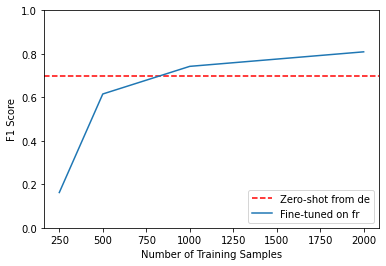

In [ ]:

fig, ax = plt.subplots()
ax.axhline(f1_scores['de']['fr'], ls='--', color='r')
metrics_df.set_index('num_samples').plot(ax=ax)
plt.legend(['Zero-shot from de', 'Fine-tuned on fr'], loc='lower right')
plt.ylim((0, 1))
plt.xlabel('Number of Training Samples')
plt.ylabel('F1 Score')
plt.show()


#Tuneado simultáneo en múltiples lenguajes a la vez.